# Light Bulb Detector

Detecting which lightbulb you have from a phone picture to make changing your lights to energy efficient solutions really easy.

### Notebook: Simple Classifier

Approach the problem as a image classification problem. 

1. Datasets
2. Trained from Scratch Classifier (2 classes)
3. Transfer Learning Classifier (2 classes)
4. Transfer Learning Classifier (8 classes)


Background: What are some of the different lightbulbs.

E27<br>
E14<br>
B22<br>
B15<br>
GU10<br>
G4<br>
G9<br>
MR16<br>

Dataset creation: Gathered images using the 'ZIP' chrome add on from a google search of the bulb type. 

Dataset sizes - about 500 images of each class

Dataset quality is not very good. Some images have multiple images of the same bulb, mostly white backgrounds and some cases where you get a picture of the box. 

references: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [40]:
import pandas as pd
import numpy as np
import itertools
import os 
import time
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.image as mpimg
import torchvision
from torchvision import models

import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [42]:
TRAIN = 'NO'

# Datasets

In [43]:
# Set up working directory
WORKING_DIR = os.getcwd()
IMAGE_DIR = WORKING_DIR.replace('bulb_classifier','bulb_data')

In [44]:
folders = ['B15','B22','E14', 'E27', 'G4', 'G9','GU10', 'MR16']

def file_rename(folders):
    '''
    Function to rename all files taken from the internet from training. Used to rename
    all the file names to avoid really long file names and make it easier to know which
    bulb it is.
    
    Could be made more generic for other projects. Eg move out the base location into a parameter.
    
    input - folder names
    
    output - all files renamed in place. 
    
    '''
    
    for bulb_type in folders:

        location = IMAGE_DIR
        location = location + '\\' + bulb_type + '\\'
        print(location)
        for count, filename in enumerate(os.listdir(location)): 
            dst = bulb_type + str(count) + ".jpg"
            src = location + filename 
            dst = location + dst  
            os.rename(src, dst) 

In [45]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=64,
                                                 num_workers=0 , sampler = train_sampler)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=4,
                                                 num_workers=0 , sampler = dev_sampler)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=4,
                                                 num_workers=0 , sampler = test_sampler)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [46]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [47]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
# We can't use random crops as it might cut off the connector

data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ])
    
light_bulbs = datasets.ImageFolder(root=IMAGE_DIR,
                                           transform=data_transform)

classes = light_bulbs.classes

In [48]:
train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])

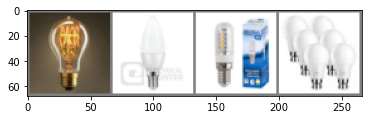

GroundTruth:    E27   E14   E14   B22


In [49]:
dataiter = iter(test)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model

In [50]:
class BulbModel(nn.Module):
    
    '''
    class which defines the bulb classifier, forward prop, training and inference methods
    
    '''
    
    def __init__(self, num_classes):
        super(BulbModel, self).__init__()
        
        '''
        Initialise the model architecture
        '''
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            nn.Flatten(),
            nn.Linear(90, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )
        # Create a criterion. Lets use cross entropy loss. 
        self.criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        # create an optimiser for the classifier
        self.optimiser = optim.Adam(self.main.parameters(), lr=0.0001, betas = (0.9,0.999))
        
    def forward(self, input):
        '''
        Use to push an image through the network. 
        input is going to be an 3 channel image
        '''
        output = self.main(input)
        return output
    
   
    def weights_init(self):
        '''
        Defining the weights_init function that takes as input a neural network
        m and that will initialize all its weights.
        '''
        classname = self.__class__.__name__
        if classname.find('Conv') != -1:
            self.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            self.weight.data.normal_(1.0, 0.02)
            self.bias.data.fill_(0)
    
    def classifer_train(self, epochs_total, train):
        '''
        Function to train classifier based on training data and set epochs
        inputs: 
            - classifer
            - number of training epochs
            - training data
        '''
        error_monitoring = []

        for epoch in range(epochs_total):
            i = 0
            for data, labels in train:

                # create the prediction using the classifier
                prediction = self.forward(data)
                error = self.criterion(prediction, labels)
                #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

                # Update the weights
                self.zero_grad()
                error.backward()
                self.optimiser.step()

                i = i + 1

            #for each epoch record the final error
            error_monitoring.append(error)
            print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
            
    def inference(self, dataset_to_test_against):
        
        '''
        function to test how good the model
        input - dataset you want to test against
        
        output - confusion matrix and recall precision. 
        '''
        predictions_total = []
        labels_total = []

        with torch.no_grad():
            for data in dataset_to_test_against:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for value in predicted:
                    predictions_total.append(value.item())
                for value in labels:
                    labels_total.append(value.item())    

        
        cm = confusion_matrix(labels_total, predictions_total)
        plot_confusion_matrix(cm, classes)

        from sklearn.metrics import precision_score, recall_score
        pre = precision_score(labels_total, predictions_total, average='micro')
        print('Precision {}'.format(round(pre,3)))
        rec = recall_score(labels_total, predictions_total, average='micro')
        print('Recall {}'.format(round(rec,3)))
        


In [51]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    ref - function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
    
    '''
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Trained from Scratch Classifier (2 or 3 classes)

In [52]:
# Create dataset just for number of classes:

NUM_CLASSES = 4

path_to_images = WORKING_DIR.strip('bulb_classifier') + 'bulb_' + str(NUM_CLASSES) + '_class'


light_bulbs = datasets.ImageFolder(root=path_to_images,
                                           transform=data_transform)

train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])


classes = light_bulbs.classes

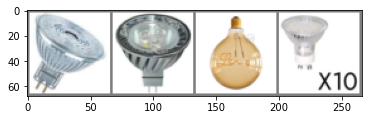

GroundTruth:   MR16  MR16   E27  GU10


In [53]:
dataiter = iter(test)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Confusion matrix, without normalization


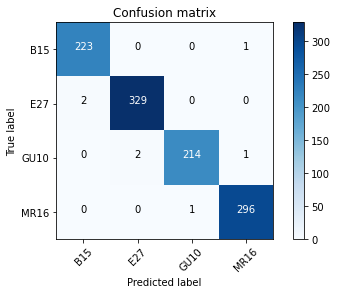

Precision 0.993
Recall 0.993
Confusion matrix, without normalization


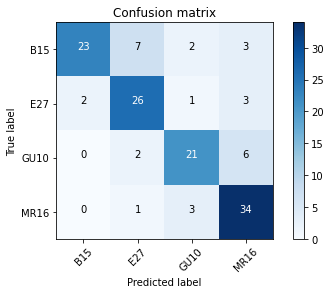

Precision 0.776
Recall 0.776
Confusion matrix, without normalization


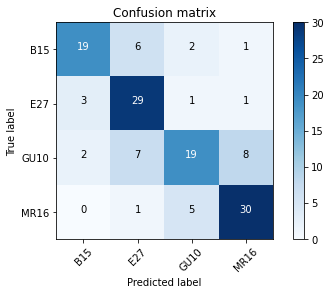

Precision 0.724
Recall 0.724


In [54]:
model = BulbModel(NUM_CLASSES)
model.weights_init()

path = './model_weights.pth'
if TRAIN == 'YES':
    model.classifer_train(50,train)
    torch.save(model.state_dict(), path)
else:
    # Load last model if not training.
    if device.type == 'cpu':
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(path))

model.inference(train)
model.inference(dev)
model.inference(test)

tensor([3, 2, 1, 2])
tensor([[1.9149e-07, 2.5085e-08, 4.9689e-06, 9.9999e-01],
        [1.0430e-02, 6.2190e-01, 1.7047e-02, 3.5062e-01],
        [7.7240e-05, 9.9984e-01, 8.3122e-05, 1.9681e-06],
        [1.4836e-05, 1.3049e-03, 1.0908e-03, 9.9759e-01]],
       grad_fn=<SoftmaxBackward>)


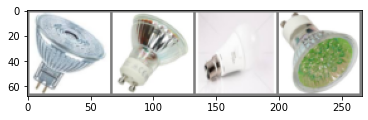

GroundTruth:   MR16  GU10   E27  GU10
Predicted  :   MR16   E27   E27  MR16


In [55]:
dataiter = iter(test)
images, labels = dataiter.next()

print(labels)

outputs = model(images)
print(outputs)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                                for j in range(len(images))))

print('Predicted  : ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(images))))



# Transfer Learning

references: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

ResNet18 with added linear layer on top. 

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [57]:
dataloaders= {'train':train, 'test':test}
dataset_sizes = {'train':len(train), 'test':len(test)}

In [58]:
def inference_transfer(model, dataset_to_test_against):
        
        '''
        function to test how good the model
        input - dataset you want to test against
        output - confusion matrix and recall precision. 
        '''
        predictions_total = []
        labels_total = []

        with torch.no_grad():
            for data in dataset_to_test_against:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for value in predicted:
                    predictions_total.append(value.item())
                for value in labels:
                    labels_total.append(value.item())    

        
        cm = confusion_matrix(labels_total, predictions_total)
        plot_confusion_matrix(cm, classes)

        from sklearn.metrics import precision_score, recall_score
        pre = precision_score(labels_total, predictions_total, average='micro')
        print('Precision {}'.format(round(pre,3)))
        rec = recall_score(labels_total, predictions_total, average='micro')
        print('Recall {}'.format(round(rec,3)))
        

In [59]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [60]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


In [61]:
path_ft = './model_weights_ft.pth'
if TRAIN == 'YES':
    model_ft = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=50)

    torch.save(model_ft.state_dict(), path_ft)
else:
    # Load last model if not training.
    if device.type == 'cpu':
        model_ft.load_state_dict(torch.load(path_ft, map_location=torch.device('cpu')))
    else:
        model_ft.load_state_dict(torch.load(path_ft))

tensor([1, 3, 1, 3])


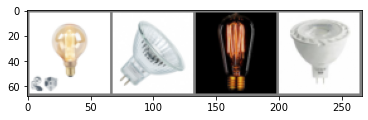

GroundTruth:    E27  MR16   E27  MR16
Predicted  :   MR16   E27   B15   E27


In [62]:
dataiter = iter(test)
images, labels = dataiter.next()

print(labels)

outputs = model_ft(images)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                                for j in range(len(images))))

print('Predicted  : ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(images))))


Confusion matrix, without normalization


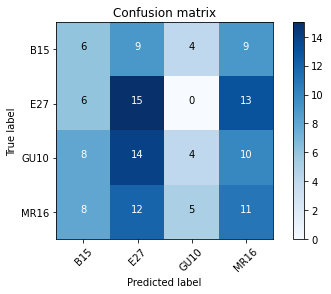

Precision 0.269
Recall 0.269


In [63]:
inference_transfer(model_ft, test)

# VGG Transfer Learn - retrain more of the layers. 

In [64]:
def retrainable_setup(model ,layers_limit):
    '''
    function that sets which layers of the network to retrain. 
    input 
    - layers_limit - number of layers to keep fixed.
    - model 
    
    output 
    - model - with layers set for training or not. 
    '''

    for param in model.parameters():
        param.requires_grad = False
    i = 0
    for child in model.children():
        for layer in child.children():
            i  +=1
            if i > layers_limit:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False


In [65]:
modelVGG = models.vgg16(pretrained=True)

In [66]:
modelVGG.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 4),                   
                      nn.Softmax(dim=1))

In [67]:
retrainable_setup(modelVGG ,layers_limit = 37)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in modelVGG.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in modelVGG.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,404 total parameters.
1,049,860 training parameters.


In [69]:
def Vgg_transfer_train(modelVGG , epochs):
    epochs_total = epochs
    
    # create an optimiser for the classifier
    optimiser_bulb_transfer = optim.Adam(model.parameters(), lr=0.01, betas = (0.9,0.999))
    # Create a criterion. Lets use cross entropy loss. 
    criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        
    for epoch in range(epochs_total):
        i = 0
        for data, labels in train:
            data = data.to(device)
            labels = labels.to(device)

            # push the image through the network
            prediction = modelVGG(data)

            error = criterion(prediction, labels)
            #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

            # zero grad
            modelVGG.zero_grad()
            error.backward()
            optimiser_bulb_transfer.step()

            #if i == 10:
            #   break

            i = i + 1
        #for each epoch record the final error
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
    return modelVGG

In [70]:
path_vgg = './model_weights_vgg.pth'
if TRAIN == 'YES':
    modelVGG = Vgg_transfer_train(modelVGG, epochs=50)
    torch.save(modelVGG.state_dict(), path_vgg)
else:
    # Load last model if not training.
    if device.type == 'cpu':
        modelVGG.load_state_dict(torch.load(path_vgg, map_location=torch.device('cpu')))
    else:
        modelVGG.load_state_dict(torch.load(path_vgg))

Confusion matrix, without normalization


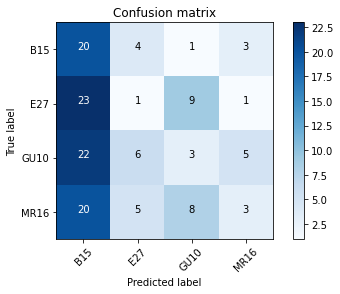

Precision 0.201
Recall 0.201


In [71]:
inference_transfer(modelVGG, test)